In [1]:
import os
import glob
import numpy as np
import awkward

In [2]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
# import matplotlib
# %matplotlib inline
# import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [5]:
# taken from the training outputs -- update if needed
presel_eff = {0: 0.0531643892564612, 1: 0.9818927295320153, 10: 0.9940605634291205, 100: 0.9957324620030694, 1000: 0.9973451587037725}

In [6]:
# FOR NOW, using only one (small) bkg file

sig_filelist = ['/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_training/output_OUTPUT.parquet']
#bkg_filelist = glob.glob('/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_large_full/*.parquet')
bkg_filelist = glob.glob('/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_kaons/output/*.parquet')


In [7]:
#sig_tables = [awkward.load(f) for f in sig_filelist]
#bkg_tables = [awkward.load(f) for f in bkg_filelist]
sig_tables = [awkward.from_parquet(f) for f in sig_filelist]
bkg_tables = [awkward.from_parquet(f) for f in bkg_filelist]
print("Loaded")
print("sig_tables:")
print(awkward.type(sig_tables[0]))
print("bkg_tables:")
print(awkward.type(bkg_tables[0]))

# Plot discValue distr, just to check...
"""bins = np.linspace(0.99, 1, 100)
plt.figure()
plt.hist(sig_tables[0]['EcalVeto_v12.discValue_'], bins=bins, density=True, histtype='step')
plt.xlim((0.99,1))
plt.semilogy()
plt.show()
print(sig_tables[0]['EcalVeto_v12.discValue_'])"""

Loaded
sig_tables:
192928 * {"TargetSPRecoilE_pt": float64, "EcalVeto_v12.discValue_": float32, "EcalVeto_v12.recoilX_": float32, "EcalVeto_v12.recoilY_": float32, "ParticleNet_extra_label": int32, "ParticleNet_disc": float32}
bkg_tables:
18086 * {"TargetSPRecoilE_pt": float64, "EcalVeto_v12.discValue_": float32, "EcalVeto_v12.recoilX_": float32, "EcalVeto_v12.recoilY_": float32, "ParticleNet_disc": float32}


"bins = np.linspace(0.99, 1, 100)\nplt.figure()\nplt.hist(sig_tables[0]['EcalVeto_v12.discValue_'], bins=bins, density=True, histtype='step')\nplt.xlim((0.99,1))\nplt.semilogy()\nplt.show()\nprint(sig_tables[0]['EcalVeto_v12.discValue_'])"

In [8]:
load_branches = [
    'EcalVeto_v12.discValue_',
    'EcalVeto_v12.recoilX_',
    'EcalVeto_v12.recoilY_',
    
    'ParticleNet_extra_label',
    'ParticleNet_disc',
    'TargetSPRecoilE_pt', # use this for plotting: this is the recoil electron pT at TargetSP
]

In [9]:
a = {}
for k in load_branches:
    print("Loading "+k)
    arrs = []
    for tab in sig_tables + bkg_tables:
        #print(awkward.type(tab))
        #print(awkward.fields(tab))
        arr = tab[k] if k in awkward.fields(tab) else np.zeros_like(tab['ParticleNet_disc'])
        arrs.append(arr)
    a[k] = awkward.concatenate(arrs)
    if k.startswith('EcalVeto'):
        #a[k] = a[k].regular()
        a[k] = awkward.to_regular(a[k])
        if a[k].ndim==2 and len(a[k][0]) == 1:  #a[k].shape[1]==1:
            a[k] = a[k][:,0]

#t_extra_labels = a['ParticleNet_extra_label']
#print("TESTING")
#print(a['TargetSPRecoilE_pt'][:100])
#print("DONE")
"""p_rec = a['EcalVeto_v12.recoilX_']
#NEW for finding frac of missing-e events
for k in presel_eff:  #Find the fraction of missing-e events for each signal category
    n_events=0
    n_missing_e=0
    for i in range(len(p_rec)):
        if t_extra_labels[i] == k:
            n_events += 1
            #if i<100:  print(p_rec[i])
            if p_rec[i] == -9999:  n_missing_e += 1
    print("Found", n_events, "events for", k, "MeV")
    print("Fraction of events w/ missing electron for "+str(k)+" MeV is ", str(n_missing_e/n_events))"""
print("Done")


Loading EcalVeto_v12.discValue_
Loading EcalVeto_v12.recoilX_
Loading EcalVeto_v12.recoilY_
Loading ParticleNet_extra_label
Loading ParticleNet_disc
Loading TargetSPRecoilE_pt
Done


In [10]:
#NEW:  Remove all hits with/without recoilX_==-999 (or -9999?) (or Y)
ntotal = len(a['EcalVeto_v12.recoilX_'])
mask = a['EcalVeto_v12.recoilX_'] != -9999
for k in load_branches:
    a[k] = a[k][mask]
print("Fraction of events without missing electron:", (ntotal-len(a[load_branches[0]]))/len(mask))

#Examine missing electrons in each category:
#NOTE:  uncertain how bkg_tables, etc are structured...
#print(sig_tables[0])

Fraction of events without missing electron: 0.10744238866359075


In [11]:
for k in a.keys():
    print(k, awkward.type(a[k]))
    #NOTE:  elements of dict are just np arrays
    #So...it should be possible to sift everything accordingly.
    
# Full size:  3395546
# Ehit size:  2789329
# Missing e size:  606217 -> Sizes are all consistent

EcalVeto_v12.discValue_ 575323 * float32
EcalVeto_v12.recoilX_ 575323 * float32
EcalVeto_v12.recoilY_ 575323 * float32
ParticleNet_extra_label 575323 * float64
ParticleNet_disc 575323 * float32
TargetSPRecoilE_pt 575323 * float64


In [12]:
def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype='int')
    categorical[np.arange(n), y] = 1
    return categorical


def plotROC(y_preds, y_truth, sample_weight=None, output=None, labels=['signal'], sig_eff=1, bkg_eff=1, energy=0, **kwargs):
    from sklearn.metrics import auc, roc_curve, accuracy_score

    fpr = dict()
    tpr = dict()
    thresholds= dict()
    roc_auc = dict()
    outputs = {}

    plt.figure()

    for label, pred in zip(labels, y_preds):
        print("ytruthlen =", len(y_truth))
        print("predlen =", len(pred))
        print("len sample_weight =", len(sample_weight))
        fpr[label], tpr[label], thresholds[label] = roc_curve(y_truth, pred, sample_weight=sample_weight)
        roc_auc[label] = auc(fpr[label], tpr[label])
        print("**Plotting", len(fpr[label]), "points")
        fpr[label] *= bkg_eff
        tpr[label] *= sig_eff

        legend = '%s (auc* = %0.6f)' % (label, roc_auc[label])
        print(legend)
        eff = get_signal_effs(fpr[label], tpr[label], thresholds[label])
        outputs[label] = eff
        print(eff)
        print("**Plotting", len(fpr[label]), "events")
        plt.plot(fpr[label], tpr[label], label=legend)
#     plt.plot([0, 1], [1, 0], 'k--')
    plt.xlim(kwargs.get('xlim', [0, 1]))
    plt.ylim(kwargs.get('ylim', [0, 1]))
    plt.xlabel('False positive rate ($\epsilon_{B}$)')
    plt.ylabel('True positive rate ($\epsilon_{S}$)')
#     plt.title('Receiver operating characteristic example')
    plt.legend(loc='best')
    if kwargs.get('logy', False):
        plt.yscale('log')
    if kwargs.get('logx', False):
        plt.xscale('log')
    plt.grid()
    # TEMPORARY TITLE
    plt.title(str(k)+" MeV", fontdict = {'fontsize' : 15})
    #plt.title("All events, "+str(k)+" MeV", fontdict = {'fontsize' : 15})
    if output:
        plt.savefig(output)
#     return {'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds}
    return outputs

mistags=[1e-3, 1e-4, 1e-5, 1e-6]
def get_signal_effs(fpr, tpr, thresholds, mistags=mistags):
    outputs = []
    for m in mistags:
        idx = next(idx for idx, v in enumerate(fpr) if v > m)
        outputs.append((fpr[idx], tpr[idx], thresholds[idx]))
    return outputs


0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999996423721313
0.9999997615814209
0.9999990463256836
0.9999998807907104
0.9999994039535522
0.9999990463256836
0.9999998807907104
0.9999998807907104
0.9999992847442627
0.9999994039535522
0.9999997615814209
0.9999997615814209
0.9999998807907104
0.9999998807907104
0.9999997615814209
0.9999992847442627
0.9999994039535522
0.9999998807907104
0.9999998807907104
0.9999997615814209
0.9999995231628418
0.9999991655349731
0.9999995231628418
0.9999994039535522
0.9999995231628418
0.9999994039535522
0.9999998807907104
0.9999991655349731
0.9999992847442627
0.9999995231628418
0.9999998807907104
0.9999997615814209
0.9999997615814209
0.9999998807

<IPython.core.display.Javascript object>


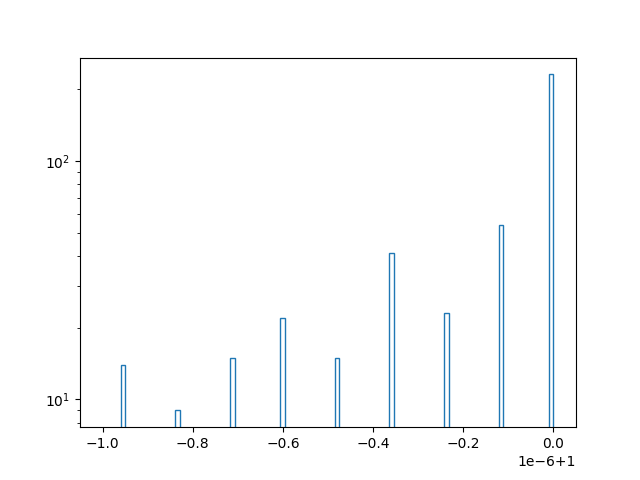

In [13]:
test_extra_labels = a['ParticleNet_extra_label']
test_labels = test_extra_labels>0

temp = a['ParticleNet_disc']
bins = np.linspace(0.999999, 1.0, 100)

PN_1 = []
for i in range(len(temp)):
    if test_extra_labels[i] == 0:  # or 10, or...
        #print(temp[i])
        PN_1.append(temp[i])
        if temp[i] > 1.0 - 1e-6 and temp[i] < 1.0:
        #    print("LESS")
            print(temp[i])
        #if temp[i] == 1.0:  print(1)
plt.figure()
plt.hist(PN_1, bins=bins, histtype='step')
plt.semilogy()
plt.show()

1 MeV


<IPython.core.display.Javascript object>


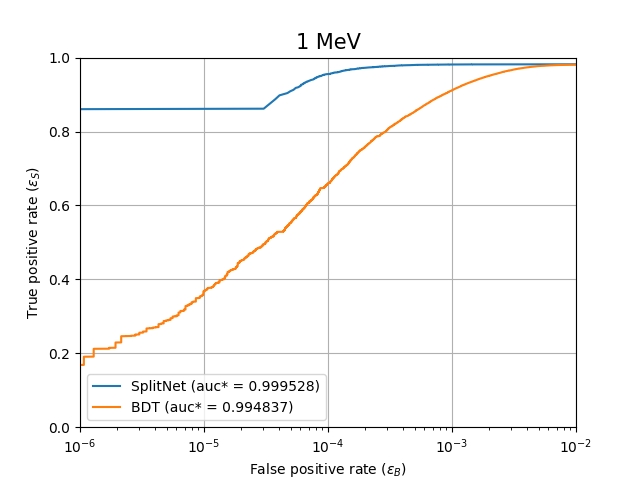

ytruthlen = 387761
predlen = 387761
len sample_weight = 387761
**Plotting 9325 points
SplitNet (auc* = 0.999528)
[(0.0010013174333918943, 0.981329988274565, 0.82090515), (0.0001023024465109555, 0.9553531257129027, 0.99998176), (3.030387596227884e-05, 0.8617747004820366, 1.0), (3.030387596227884e-05, 0.8617747004820366, 1.0)]
**Plotting 9325 events
ytruthlen = 387761
predlen = 387761
len sample_weight = 387761
**Plotting 51110 points
BDT (auc* = 0.994837)
[(0.001000242827861317, 0.9113322370252499, 0.017668366), (0.00010015323544980097, 0.6591696948561018, 0.83713746), (1.010129198742628e-05, 0.367361123452383, 0.9973978), (1.0746055305772637e-06, 0.1682777889214602, 0.9997799)]
**Plotting 51110 events
10 MeV


<IPython.core.display.Javascript object>


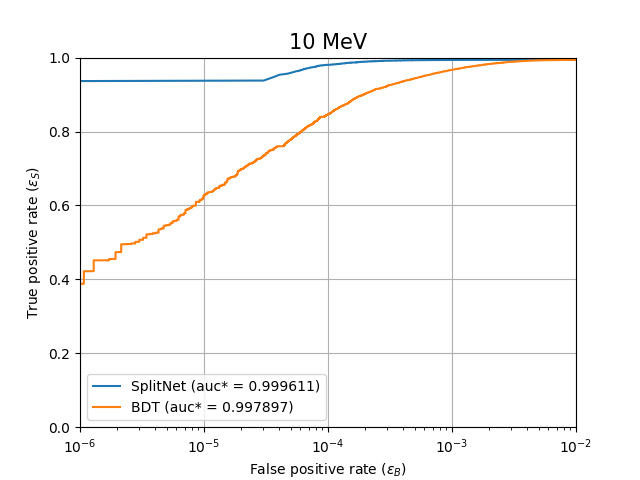

ytruthlen = 387761
predlen = 387761
len sample_weight = 387761
**Plotting 9093 points
SplitNet (auc* = 0.999611)
[(0.0010013174333918943, 0.9936574569557105, 0.82090515), (0.0001023024465109555, 0.9803213511270622, 0.99998176), (3.030387596227884e-05, 0.9378943948006571, 1.0), (3.030387596227884e-05, 0.9378943948006571, 1.0)]
**Plotting 9093 events
ytruthlen = 387761
predlen = 387761
len sample_weight = 387761
**Plotting 41853 points
BDT (auc* = 0.997897)
[(0.001000242827861317, 0.9669516530922964, 0.017668366), (0.00010015323544980097, 0.8462548565121115, 0.83713746), (1.010129198742628e-05, 0.6265618285036482, 0.9973978), (1.0746055305772637e-06, 0.38795638845103114, 0.9997799)]
**Plotting 41853 events
100 MeV


<IPython.core.display.Javascript object>


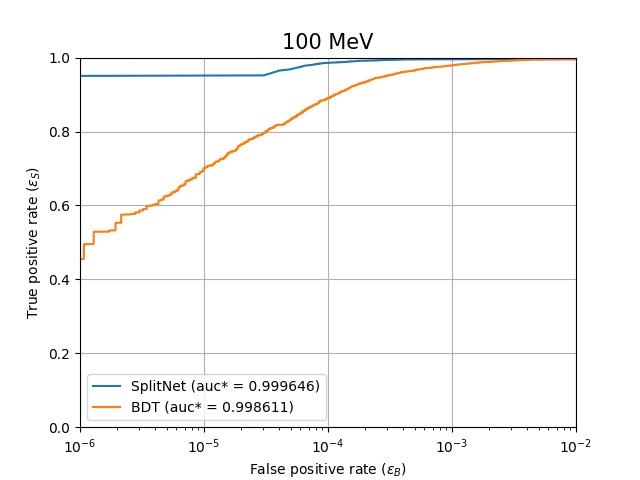

ytruthlen = 387761
predlen = 387761
len sample_weight = 387761
**Plotting 9005 points
SplitNet (auc* = 0.999646)
[(0.0010013174333918943, 0.9955226242786074, 0.82090515), (0.0001023024465109555, 0.9857651700911267, 0.99998176), (3.030387596227884e-05, 0.9518763775905218, 1.0), (3.030387596227884e-05, 0.9518763775905218, 1.0)]
**Plotting 9005 events
ytruthlen = 387761
predlen = 387761
len sample_weight = 387761
**Plotting 34413 points
BDT (auc* = 0.998611)
[(0.001000242827861317, 0.9788405251838824, 0.017668366), (0.00010015323544980097, 0.8902890054609394, 0.83713746), (1.010129198742628e-05, 0.6995465139250266, 0.9973978), (1.0746055305772637e-06, 0.4547183489090462, 0.9997799)]
**Plotting 34413 events
1000 MeV


<IPython.core.display.Javascript object>


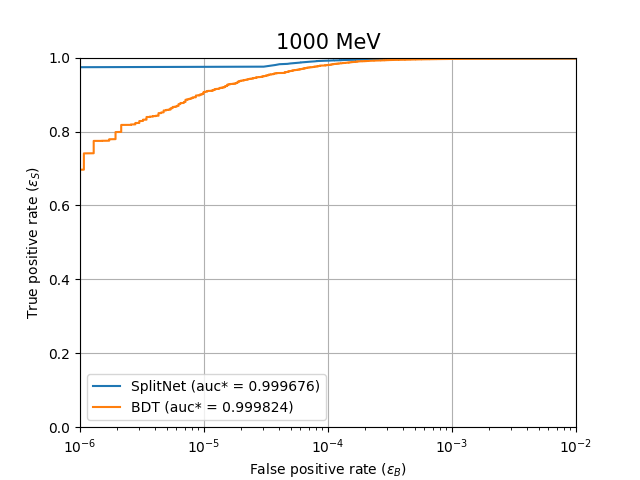

ytruthlen = 387761
predlen = 387761
len sample_weight = 387761
**Plotting 9002 points
SplitNet (auc* = 0.999676)
[(0.0010013174333918943, 0.9971601274003105, 0.82090515), (0.0001023024465109555, 0.991714920469856, 0.99998176), (3.030387596227884e-05, 0.9754850318518995, 1.0), (3.030387596227884e-05, 0.9754850318518995, 1.0)]
**Plotting 9002 events
ytruthlen = 387761
predlen = 387761
len sample_weight = 387761
**Plotting 32396 points
BDT (auc* = 0.999824)
[(0.001000242827861317, 0.9963407030564071, 0.017668366), (0.00010015323544980097, 0.9800315153083955, 0.83713746), (1.010129198742628e-05, 0.9060718600102811, 0.9973978), (1.0746055305772637e-06, 0.6965106923178396, 0.9997799)]
**Plotting 32396 events


In [85]:
roc_info = {}
for k in presel_eff:
    if k > 0:
        mass = '%d MeV' % k
        print(mass)
        roc_info[k] = plotROC([a['ParticleNet_disc'], a['EcalVeto_v12.discValue_']], test_labels, 
                sample_weight=np.logical_or(test_extra_labels == 0, test_extra_labels == k),
                sig_eff=presel_eff[k], bkg_eff=presel_eff[0],
                labels=['SplitNet', 'BDT'], xlim=[1e-6, .01], ylim=[0, 1], logx=True, energy=k)
        #**NOTE:**  The sample_weight line is critical!!  Selects only bkg+sig[k].

In [76]:
roc_info

{1: {'SplitNet': [(0.0010004972424251556, 0.9814752118248747, 0.6651679),
   (0.00010586174141842933, 0.9597279851659848, 0.9999691),
   (2.1795064409676625e-05, 0.8617747004820366, 1.0),
   (2.1795064409676625e-05, 0.8617747004820366, 1.0)],
  'BDT': [(0.0010004972424251556, 0.937254640755546, 0.007561207),
   (0.00010067244036850632, 0.7536013084450377, 0.43480444),
   (1.0378602099846012e-05, 0.508990390891998, 0.9832735),
   (1.0378602099846013e-06, 0.24738831795271407, 0.9994205)]},
 10: {'SplitNet': [(0.0010004972424251556, 0.9938590101924155, 0.6651679),
   (0.00010586174141842933, 0.9820009614329372, 0.9999691),
   (2.1795064409676625e-05, 0.9378943948006571, 1.0),
   (2.1795064409676625e-05, 0.9378943948006571, 1.0)],
  'BDT': [(0.0010004972424251556, 0.9769957227214295, 0.007561207),
   (0.00010067244036850632, 0.8993305421777648, 0.43480444),
   (1.0378602099846012e-05, 0.7464860043431305, 0.9832735),
   (1.0378602099846013e-06, 0.49706387392067775, 0.9994205)]},
 100: {'Spl

In [57]:
plot_bins = {
#     'EcalVetoGabriel_recon.nReadoutHits_':np.linspace(0, 50, 51),
#     'EcalVetoGabriel_recon.deepestLayerHit_':np.linspace(0, 35, 36),
#     'EcalVetoGabriel_recon.summedDet_':np.linspace(0, 2000, 41),
#     'EcalVetoGabriel_recon.summedTightIso_':np.linspace(0, 400, 41),
#     'EcalVetoGabriel_recon.maxCellDep_':np.linspace(0, 400, 41),
#     'EcalVetoGabriel_recon.showerRMS_':np.linspace(0, 250, 26),
#     'EcalVetoGabriel_recon.xStd_':np.linspace(0, 200, 41),
#     'EcalVetoGabriel_recon.yStd_':np.linspace(0, 200, 41),
#     'EcalVetoGabriel_recon.avgLayerHit_':np.linspace(0, 35, 36),
#     'EcalVetoGabriel_recon.stdLayerHit_':np.linspace(0, 20, 21),
#     'EcalVetoGabriel_recon.ecalBackEnergy_':np.linspace(0, 200, 41),
# #     'EcalVetoGabriel_recon.discValue_':np.linspace(0.9, 1, 51),
#     'EcalVetoGabriel_recon.recoilX_':np.linspace(-400, 400, 81),
#     'EcalVetoGabriel_recon.recoilY_':np.linspace(-400, 400, 81),

    'TargetSPRecoilE_pt':np.linspace(-50, 200, 51),

#     'ParticleNet_disc':np.linspace(0, 1, 51),
}

# plot_bins = {
#     'EcalVetoGabriel_recon.ecalLayerEdepReadout_:%d'%i:np.linspace(0, 1000, 51) for i in range(34)
# }


In [52]:
colors = ['#636363', '#74c476', '#3182bd', '#f03b20', '#bd0026']
colors = None

In [53]:
def plot_sig_vs_bkg(var_name):
    if ':' in var_name:
        var, var_idx = var_name.split(':')
        var_idx = int(var_idx)
    else:
        var, var_idx = var_name, None

    arrays = []
    labels = []
    for proc in presel_eff.keys():
        pos = test_extra_labels==proc
        arr = a[var][pos]
        # NEW:  See if direct awkward conversion works
        arr = np.array(arr)
        if var_idx:
            arr = arr[:, var_idx]
        if not isinstance(plot_bins[var_name], int):
            arr = np.clip(arr, min(plot_bins[var_name]), max(plot_bins[var_name]))
        arrays.append(arr)
        labels.append('BKG' if proc==0 else '%d MeV'%proc)
    f = plt.figure()
    #TEMP TITLE
    #plt.title("Events without SP hit")
    plt.title("All events")
    #NOTE:  normed=True caused an error; removing it temporarily
    plt.hist(arrays, bins=plot_bins[var_name], label=labels, histtype='step', log=True)
    plt.legend()
    plt.xlabel(var_name)

In [54]:
# plot_sig_vs_bkg('TargetSPRecoilE_pt')

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


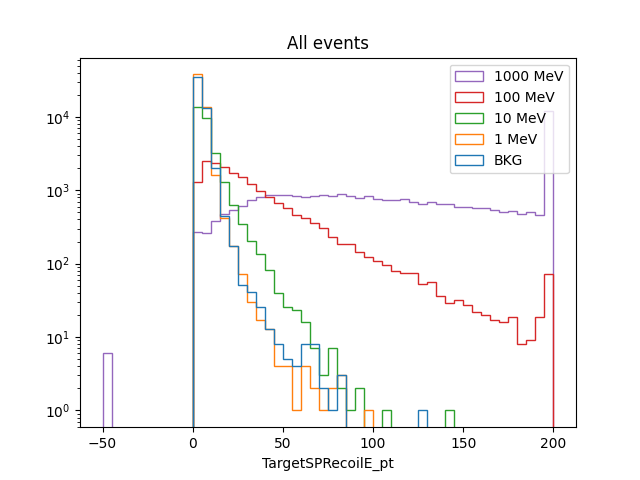

In [55]:
for var in plot_bins:
    print(var)
    plot_sig_vs_bkg(var)

In [56]:
def plot_trend(var_name, proc, eff_levels=None, mistag_levels=[1e-3, 1e-4, 1e-5, 1e-6]):
    if ':' in var_name:
        var, var_idx = var_name.split(':')
        var_idx = int(var_idx)
    else:
        var, var_idx = var_name, None
    if eff_levels is None and mistag_levels is None:
        eff_levels = [1e-3, 1e-4, 1e-5, 1e-6] if proc==0 else [0.9, 0.7, 0.5, 0.2]
    f, axes = plt.subplots(1, 2, figsize=(12, 5))
    f.suptitle('%d MeV'%proc if proc>0 else 'BKG', fontsize=16)
    pos0 = test_extra_labels==proc
    #a_tmp = {k:a[k][pos0] for k in ('ParticleNet_disc', 'EcalVetoGabriel_recon.discValue_', var)}
    # TESTING CONVERSION:
    a_tmp = {k:np.array(a[k][pos0]) for k in ('ParticleNet_disc', 'EcalVeto_v12.discValue_', var)}
    if var_idx:
        a_tmp[var] = a_tmp[var][:, var_idx]
    for i, k in enumerate(['ParticleNet_disc', 'EcalVeto_v12.discValue_']):
        arrs = []
        labels = []
        scores = a_tmp[k]
        if mistag_levels is None:  #NOTE:  Currently modifying this to produce fixed bkg efficiencies...
            #Changing presel_eff[proc] to 1 (Warning:  bkg will be messed up)
            pcts = (1 - np.array(eff_levels)/presel_eff[1]) * 100.
            print('effs=', pcts)
            thresholds = [-99] + list(np.percentile(scores, pcts))
        else:
            thresholds = [-99] + [info[-1] for info in roc_info[1]['SplitNet' if i==0 else 'BDT']]
        print(k, thresholds)
        for idx, thres in enumerate(thresholds):
            pos = scores>thres
#             print(k, thres, pos.sum())
            if not isinstance(plot_bins[var_name], int):
                arrs.append(np.clip(a_tmp[var][pos], min(plot_bins[var_name]), max(plot_bins[var_name])))
            else:
                arrs.append(a_tmp[var][pos])
            if mistag_levels is None:
                labels.append('inclusive' if idx==0 else ('$\epsilon_{B}$=%.0e'%eff_levels[idx-1] if proc==0 else '$\epsilon_{S}$=%.1f'%eff_levels[idx-1]))
            else:
                labels.append('inclusive' if idx==0 else '$\epsilon_{B}$=%.0e'%mistag_levels[idx-1])

        axes[i].hist(arrs, histtype='step', bins=plot_bins[var_name], density=True, log=True, label=labels, color=colors, linewidth=2)
        axes[i].set_title('ParticleNet' if i==0 else 'BDT')  #, '+str(proc if proc>0 else 'BKG')+' MeV
        axes[i].set_xlabel(var)
        axes[i].set_ylim(1e-6, 30)
        axes[i].legend(loc='best')

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


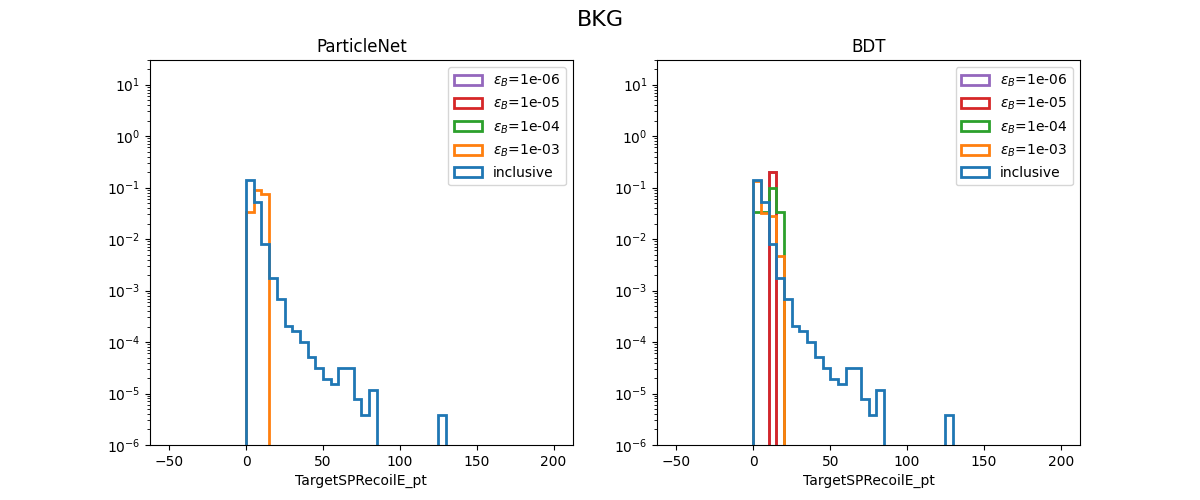

effs= [99.89815588 99.98981559 99.99898156 99.99989816]
ParticleNet_disc [-99, 0.9999931447631641, 1.0, 1.0, 1.0]
effs= [99.89815588 99.98981559 99.99898156 99.99989816]
EcalVeto_v12.discValue_ [-99, 0.8654544949531555, 0.9967320894346179, 0.9993207711160665, 0.9994105483907513]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


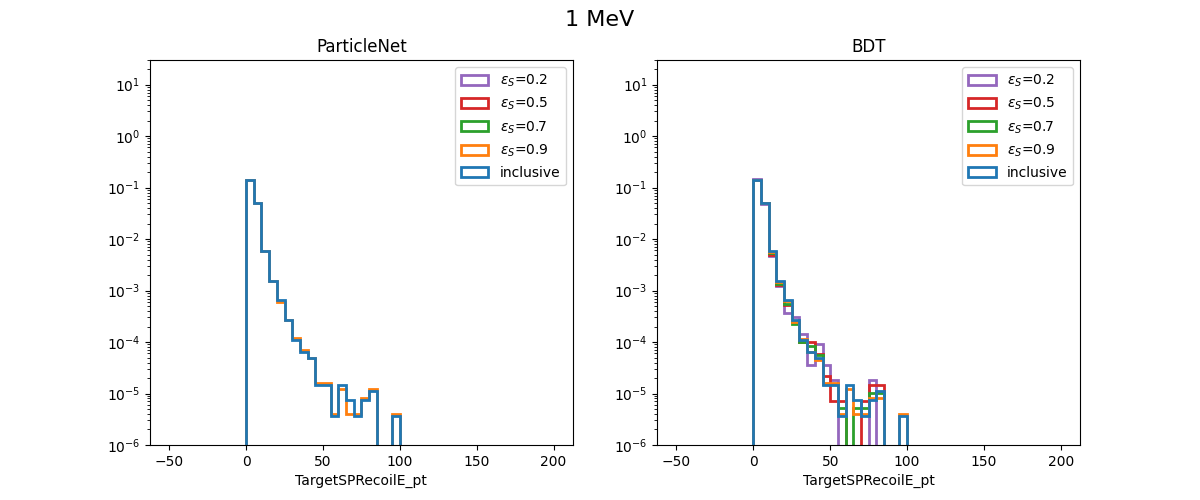

effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
ParticleNet_disc [-99, 0.9999996423721313, 1.0, 1.0, 1.0]
effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
EcalVeto_v12.discValue_ [-99, 0.02415571691579836, 0.6985915041117544, 0.9852539043757282, 0.9996738433837891]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


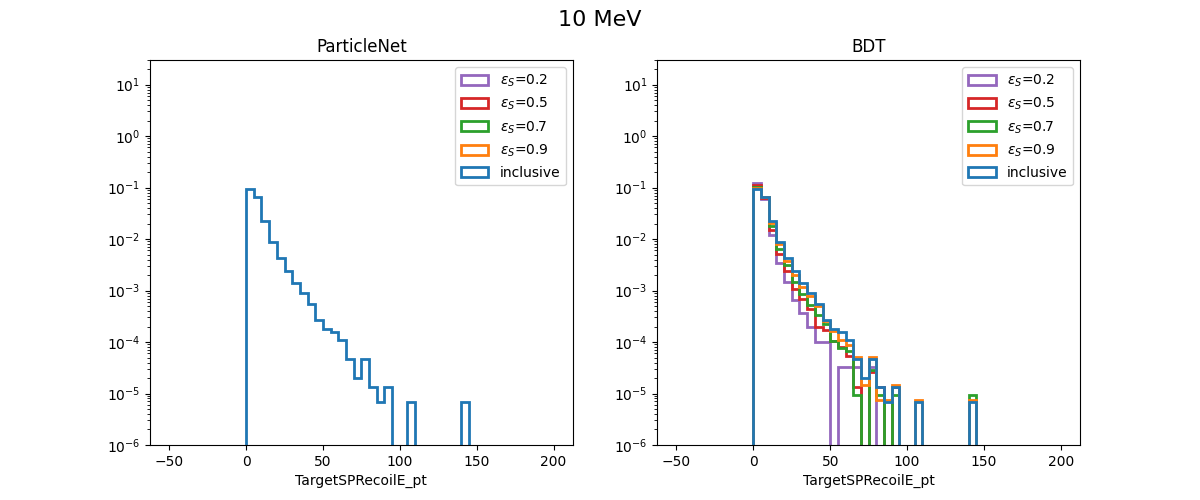

effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]
effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
EcalVeto_v12.discValue_ [-99, 0.3156802790295607, 0.9910345970073644, 0.9993646740913391, 0.9999364614486694]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


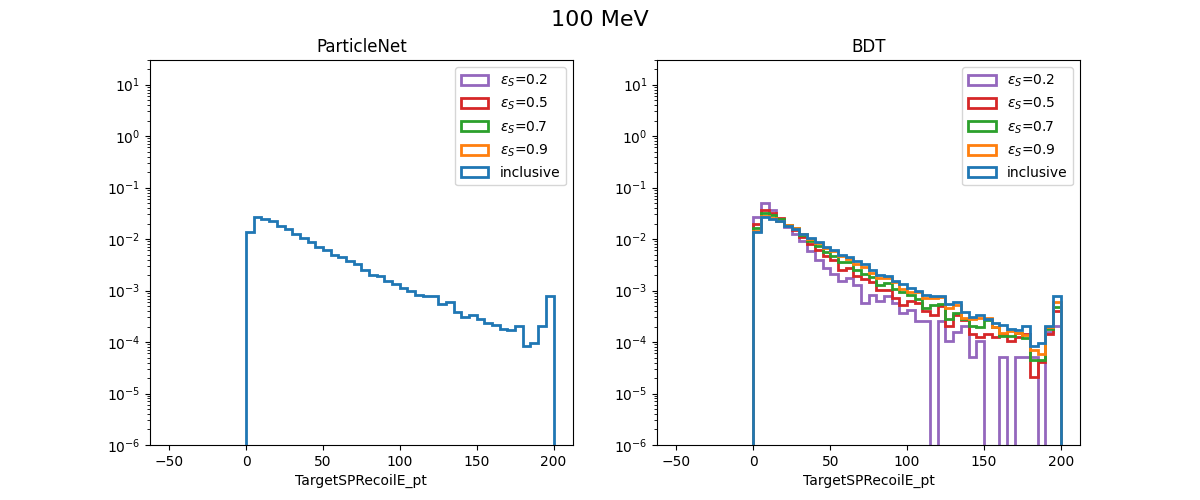

effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]
effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
EcalVeto_v12.discValue_ [-99, 0.6672120741662387, 0.9969612823734479, 0.9996805191040039, 0.9999483823776245]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


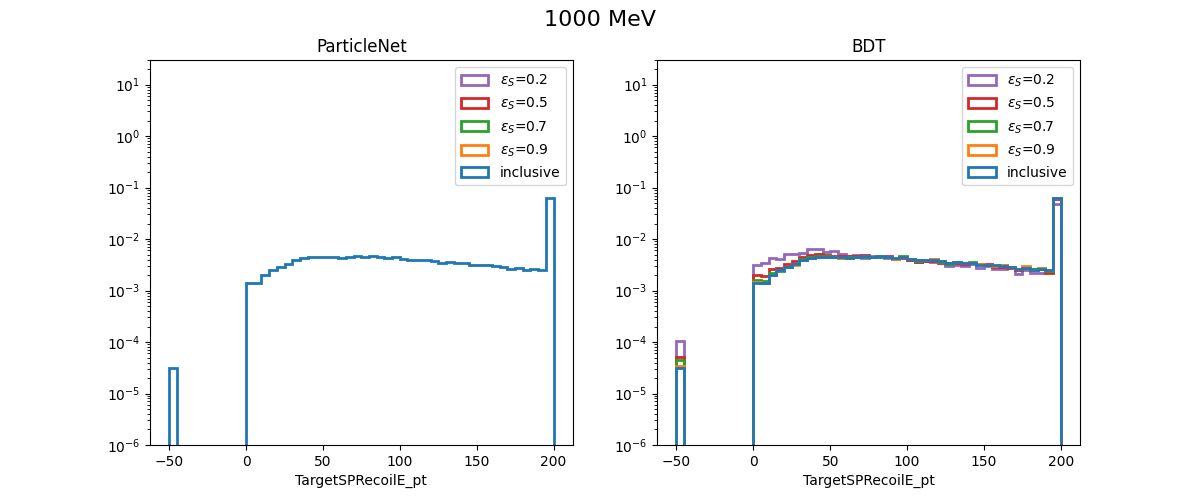

effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]
effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
EcalVeto_v12.discValue_ [-99, 0.996699964107072, 0.9997605681419373, 0.999901533126831, 0.9999704360961914]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [57]:
# compare shapes with succesively tighter selections
# keep BKG mistag rate the same for all signal points

for var in plot_bins:
    print(var)
    plot_trend(var, proc=0, mistag_levels=None)
    plot_trend(var, proc=1, mistag_levels=None)
    plot_trend(var, proc=10, mistag_levels=None)
    plot_trend(var, proc=100, mistag_levels=None)
    plot_trend(var, proc=1000, mistag_levels=None)

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


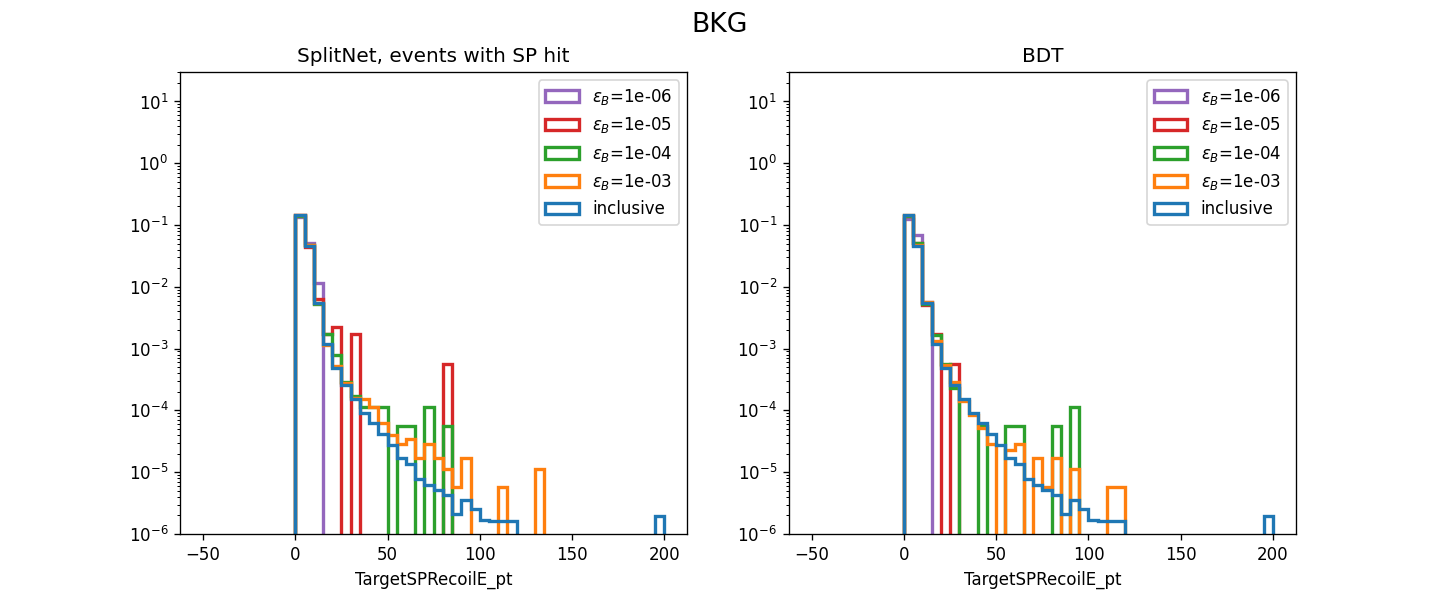

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


<IPython.core.display.Javascript object>


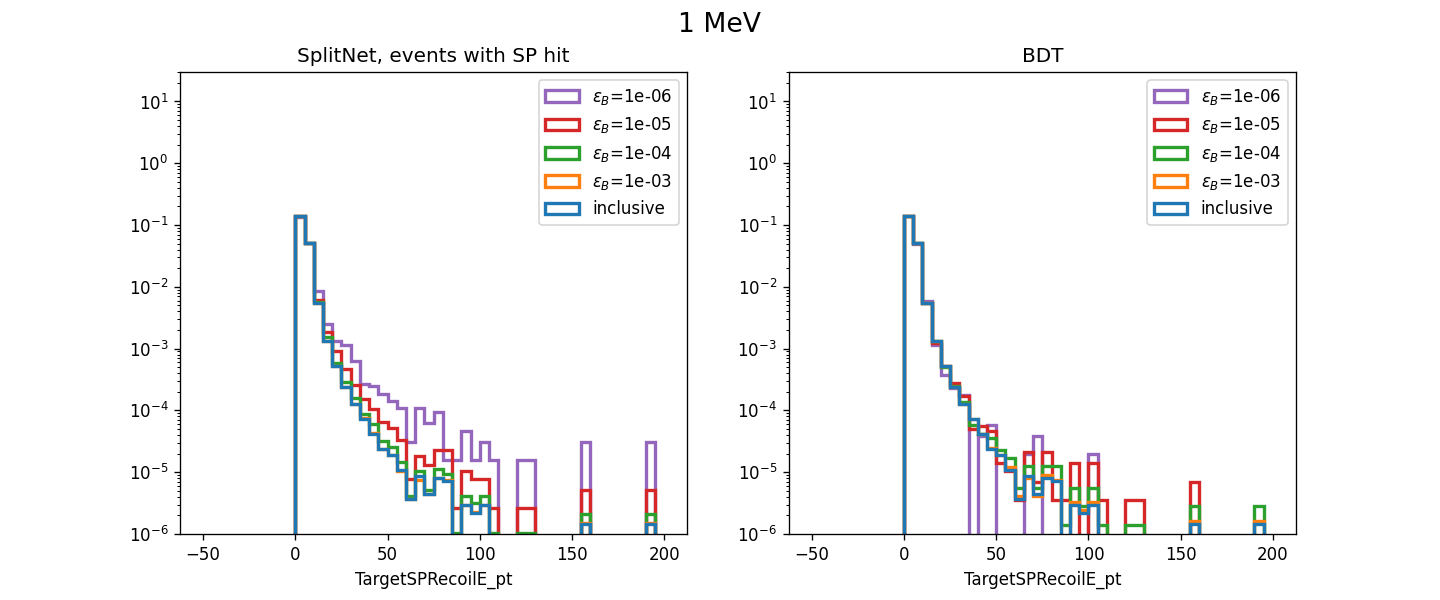

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


<IPython.core.display.Javascript object>


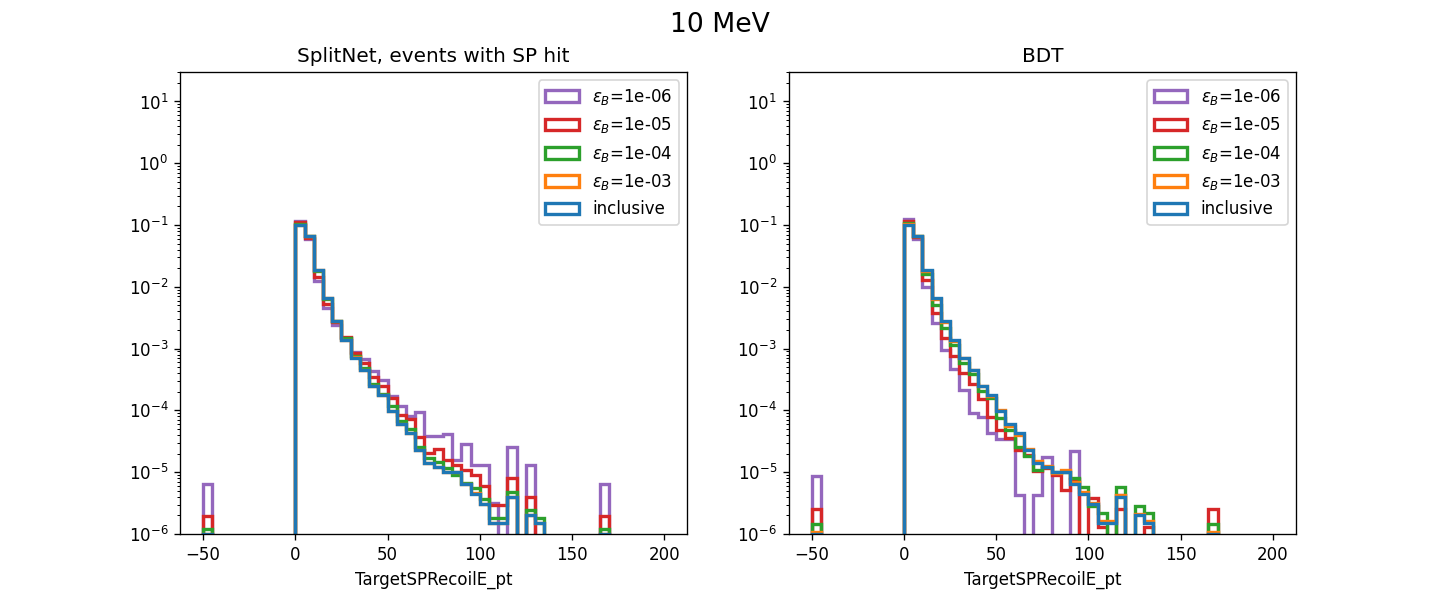

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


<IPython.core.display.Javascript object>


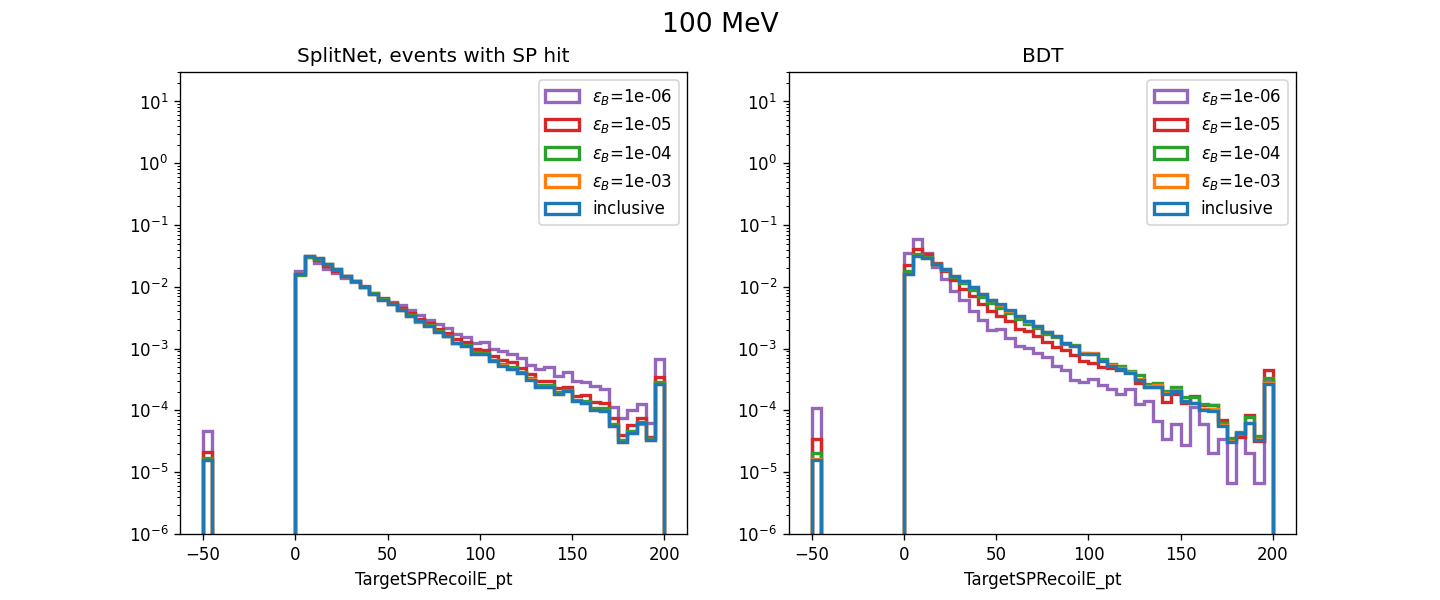

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


<IPython.core.display.Javascript object>


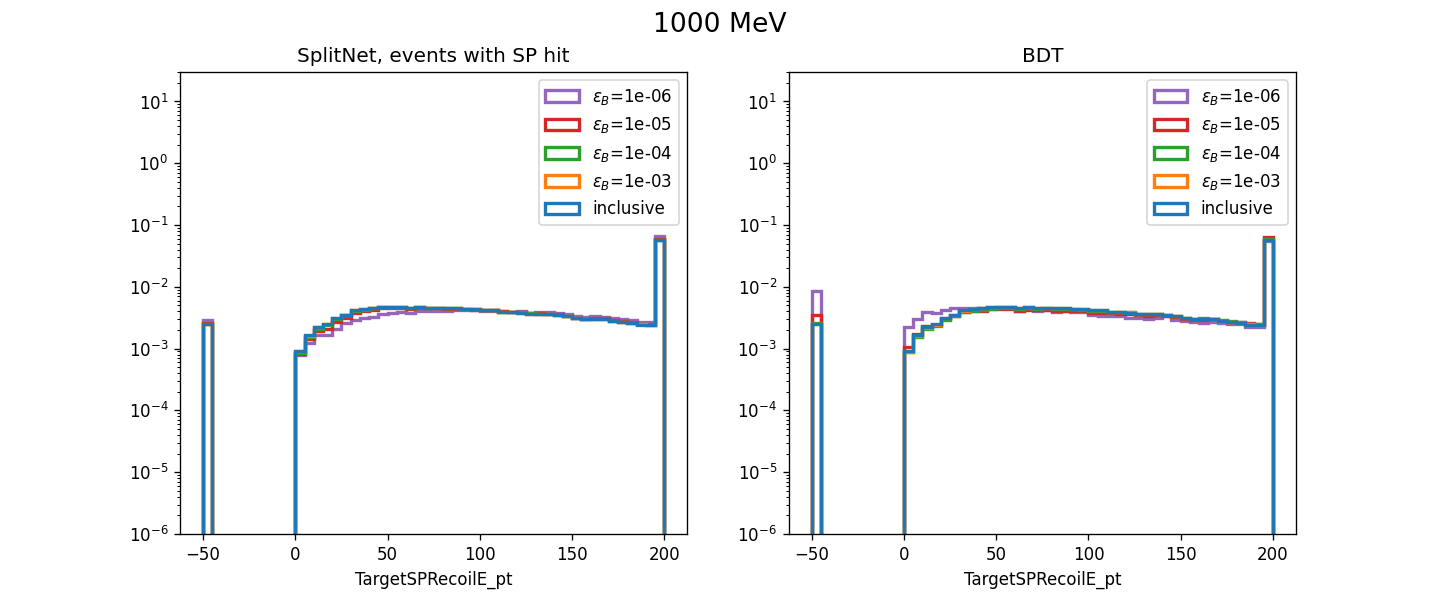

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


In [171]:
# compare shapes with succesively tighter selections
# keep SIG efficiency the same for all signal points

for var in plot_bins:
    print(var)
    plot_trend(var, proc=0)
    plot_trend(var, proc=1)
    plot_trend(var, proc=10)
    plot_trend(var, proc=100)
    plot_trend(var, proc=1000)
    
# All:  pT bias still visible in 10MeV
# SP hit:  pT bias mostly gone
# No SP hit:  no pT bias, as usual